In [ ]:
!pip install mlxtend

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

from IPython.display import display, Markdown

In [ ]:
# Import data from Github

url = "https://raw.githubusercontent.com/king123git62/COMP7404-Group31/0535f1b88f893e7767479895d08fbb1baee7fdf6/Real-world%20churn%20dataset.csv"
filename = "Real-world_churn_dataset.csv"

urllib.request.urlretrieve(url, filename)

df = pd.read_csv(filename)

if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

df.dropna(inplace=True)

df.replace({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0}, inplace=True)

if 'MultipleLines' in df.columns:
    df['MultipleLines'].replace({0: 2, 'No phone service': 0}, inplace=True)

if 'InternetService' in df.columns:
    df['InternetService'].replace({'DSL': 1, 'Fiber optic': 2}, inplace=True)

columns_to_update = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]
for col in columns_to_update:
    if col in df.columns:
        df[col].replace({0: 2, 'No internet service': 0}, inplace=True)

if 'Contract' in df.columns:
    df['Contract'].replace({'Month-to-month': 0, 'One year': 1, 'Two year': 2}, inplace=True)

if 'PaymentMethod' in df.columns:
    df['PaymentMethod'].replace({
        'Electronic check': 5,
        'Mailed check': 6,
        'Bank transfer (automatic)': 3,
        'Credit card (automatic)': 4
    }, inplace=True)

if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    df.dropna(inplace=True)

df.to_csv('processed_data.csv', index=False)
print("Data cleaned and saved as 'processed_data.csv'")

<ipython-input-2-3fd2ab44e1d4>:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0}, inplace=True)
<ipython-input-2-3fd2ab44e1d4>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['MultipleLines'].replace({0: 2, 'No phone service': 0}, inplace=T

Data cleaned and saved as 'processed_data.csv'


In [ ]:
df = pd.read_csv('processed_data.csv')

scaler = StandardScaler()
X = df.drop(columns=['Churn'])
X_scaled = scaler.fit_transform(X)
y = df['Churn']

X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=7404)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=7404)

preprocessed_data = {
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test,
    "y_train": y_train,
    "y_val": y_val,
    "y_test": y_test,
    "X_scaled": X_scaled,
    "y": y
}

In [ ]:
def preprocess_features(X_train, y_train, X_val, X_test):

    selector = SelectKBest(score_func=f_classif, k=12)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_val_selected = selector.transform(X_val)
    X_test_selected = selector.transform(X_test)

    pca = PCA(n_components=8)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)

    return X_train_selected, X_val_selected, X_test_selected, X_train_pca, X_val_pca, X_test_pca

In [ ]:
# Multilayer perceptron

tf.config.optimizer.set_jit(True)

def train_mlp(X_train, y_train, X_test, y_test, hidden_layers, max_epochs, checkpoints):
    model = Sequential()

    for units in hidden_layers:
        model.add(Dense(units, activation='sigmoid'))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = keras.optimizers.SGD()

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    results = {}

    for epoch in range(1, max_epochs + 1):
        model.fit(X_train, y_train, epochs=1, batch_size=64, verbose=0)

        if epoch in checkpoints:
            loss, acc = model.evaluate(X_test, y_test, verbose=0)
            results[epoch] = round(acc * 100, 1)

    return results

X_train = preprocessed_data["X_train"]
X_val = preprocessed_data["X_val"]
X_test = preprocessed_data["X_test"]
y_train = preprocessed_data["y_train"]
y_test = preprocessed_data["y_test"]

X_train_selected, X_val_selected, X_test_selected, X_train_pca, X_val_pca, X_test_pca = preprocess_features(X_train, y_train, X_val, X_test)

experiments = [
    [9, 6, 3],
    [30, 1],
    [10, 1],
    [10, 5, 3],
]

max_epochs = 2500
checkpoints = [1500, 2000, 2500]
results = []

feature_counts = {
    "original": X_train.shape[1],
    "selected": X_train_selected.shape[1],
    "pca": X_train_pca.shape[1]
}

for hidden_layers in experiments:

    acc_results = train_mlp(X_train, y_train, X_test, y_test, hidden_layers, max_epochs, checkpoints)

    corre_results = train_mlp(X_train_selected, y_train, X_test_selected, y_test, hidden_layers, max_epochs, checkpoints)

    pca_results = train_mlp(X_train_pca, y_train, X_test_pca, y_test, hidden_layers, max_epochs, checkpoints)

    for epoch in checkpoints:
        results.append([
            epoch, str(hidden_layers),
            f"{acc_results[epoch]}%", feature_counts["original"],
            f"{corre_results[epoch]}%", feature_counts["selected"],
            f"{pca_results[epoch]}%", feature_counts["pca"]
        ])

columns = ["Epoch", "Hidden Layers", "Performance", "Original Features",
           "Correlation Performance", "Selected Features",
           "PCA Performance", "PCA Features"]

df = pd.DataFrame(results, columns=columns)

print(df.to_markdown(index=False))

|   Epoch | Hidden Layers   | Performance   |   Original Features | Correlation Performance   |   Selected Features | PCA Performance   |   PCA Features |
|--------:|:----------------|:--------------|--------------------:|:--------------------------|--------------------:|:------------------|---------------:|
|    1500 | [9, 6, 3]       | 79.4%         |                  19 | 79.3%                     |                  12 | 79.2%             |              8 |
|    2000 | [9, 6, 3]       | 79.8%         |                  19 | 79.3%                     |                  12 | 78.8%             |              8 |
|    2500 | [9, 6, 3]       | 79.3%         |                  19 | 79.8%                     |                  12 | 79.3%             |              8 |
|    1500 | [30, 1]         | 80.1%         |                  19 | 80.3%                     |                  12 | 78.4%             |              8 |
|    2000 | [30, 1]         | 80.2%         |                  19 | 80

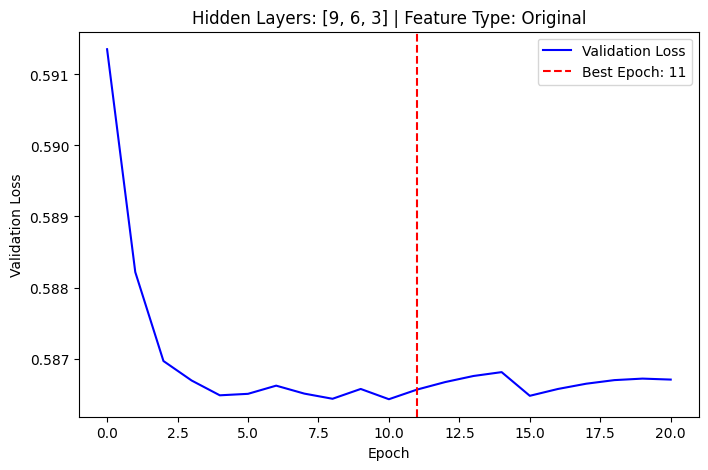

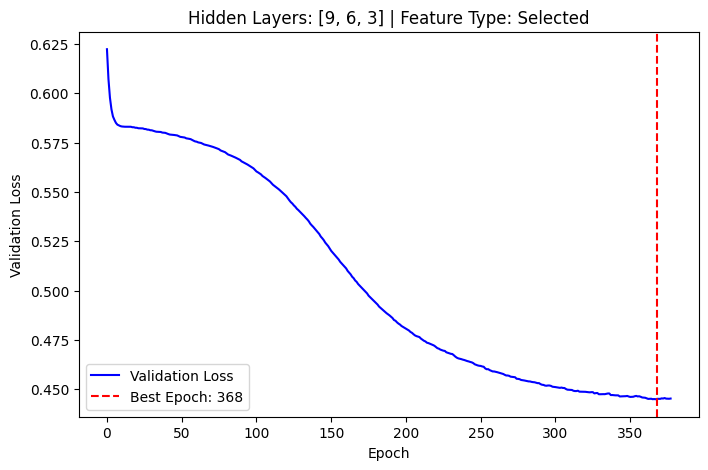

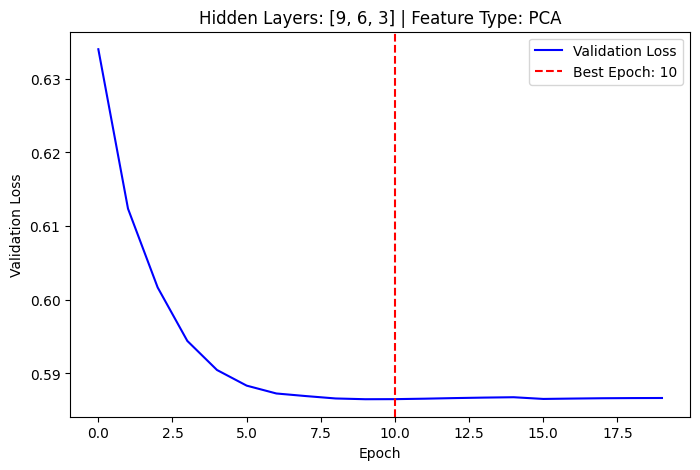

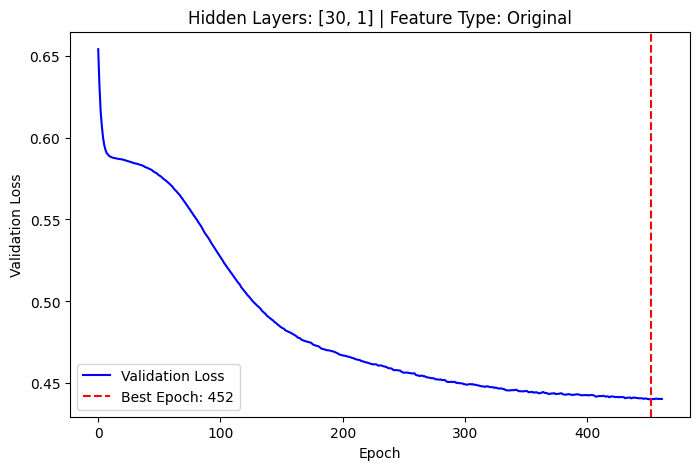

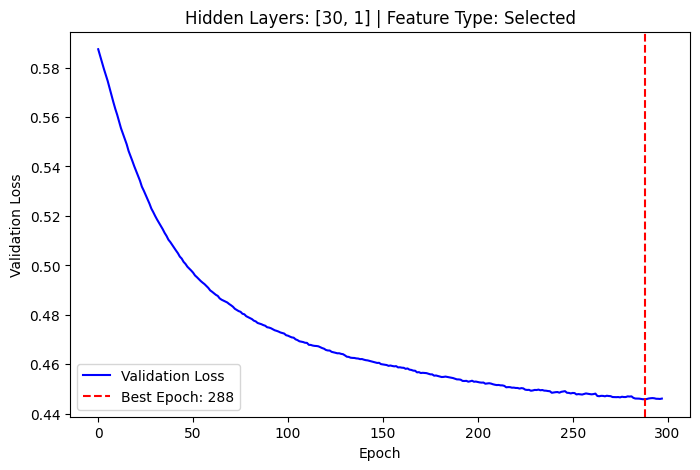

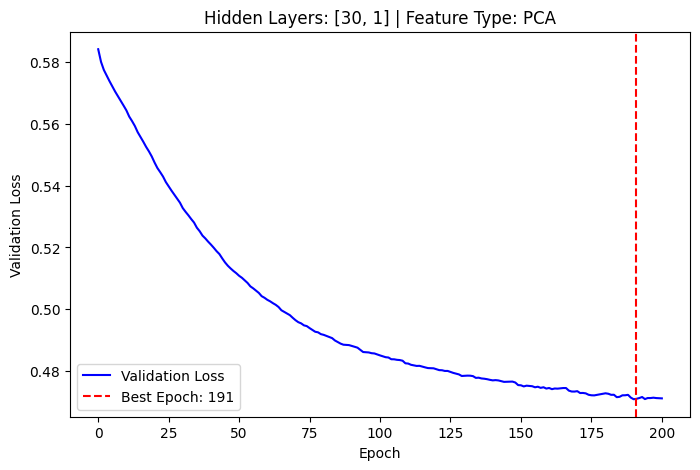

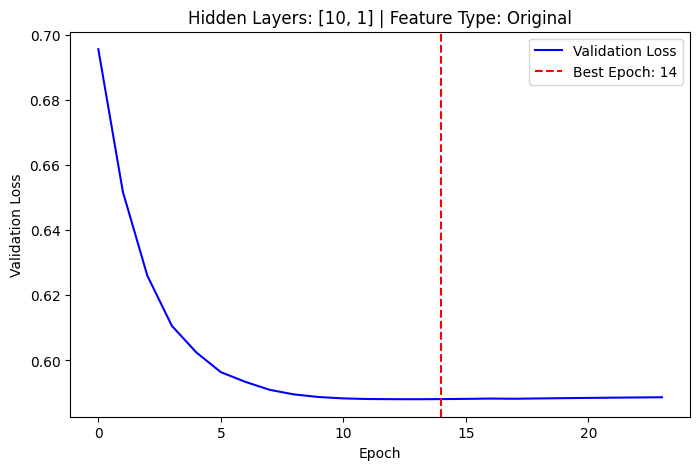

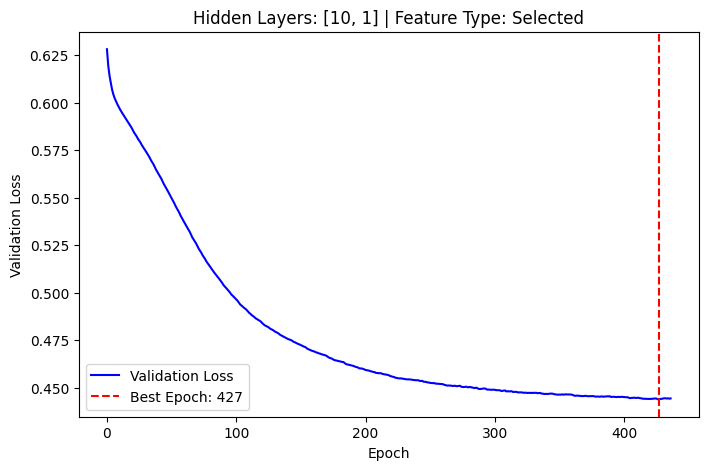

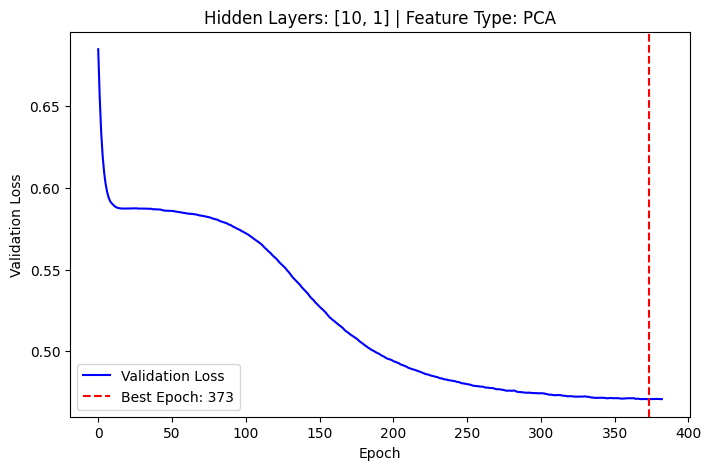

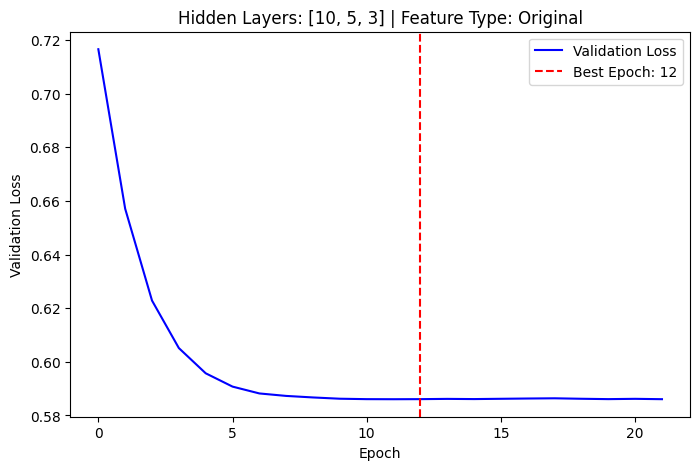

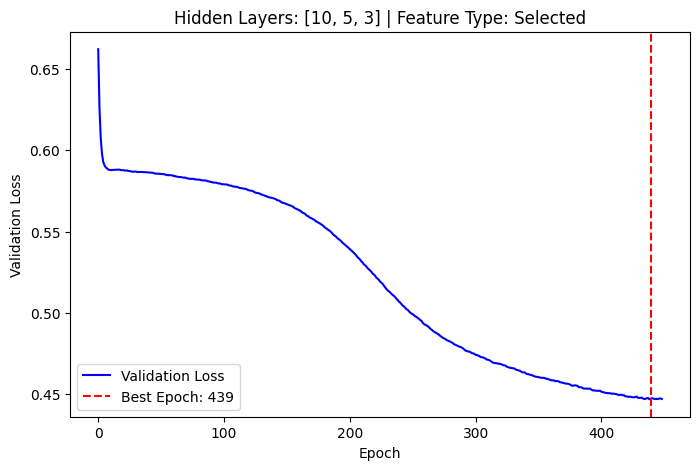

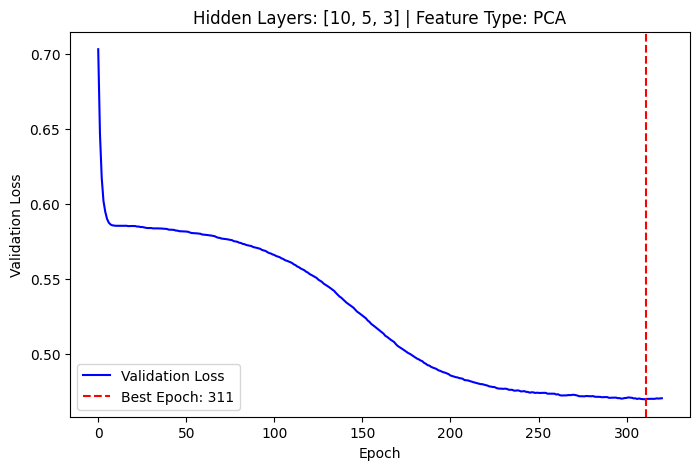

| Hidden Layers   |   Number of Features |   Best Epoch | Feature Type      | Test Performance   |
|:----------------|---------------------:|-------------:|:------------------|:-------------------|
| [9, 6, 3]       |                   19 |           11 | Original Features | 72.1%              |
| [9, 6, 3]       |                   12 |          368 | Selected Features | 79.2%              |
| [9, 6, 3]       |                    8 |           10 | PCA Features      | 72.1%              |
| [30, 1]         |                   19 |          452 | Original Features | 79.6%              |
| [30, 1]         |                   12 |          288 | Selected Features | 79.3%              |
| [30, 1]         |                    8 |          191 | PCA Features      | 78.0%              |
| [10, 1]         |                   19 |           14 | Original Features | 72.1%              |
| [10, 1]         |                   12 |          427 | Selected Features | 78.5%              |
| [10, 1] 

In [ ]:
# Multilayer perceptron (With loss curve)

tf.config.optimizer.set_jit(True)

def train_mlp(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layers, patience):
    model = Sequential()
    for units in hidden_layers:
        model.add(Dense(units, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = keras.optimizers.SGD()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(
        monitor="val_loss", patience=patience, restore_best_weights=True
    )

    history = model.fit(X_train, y_train, epochs=9999999, batch_size=64, verbose=0,
                        validation_data=(X_val, y_val), callbacks=[early_stopping])

    best_epoch = early_stopping.stopped_epoch - patience + 1

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    test_accuracy = round(test_accuracy * 100, 1)

    return best_epoch, test_accuracy, history

X_train = preprocessed_data["X_train"]
X_val = preprocessed_data["X_val"]
X_test = preprocessed_data["X_test"]
y_train = preprocessed_data["y_train"]
y_val = preprocessed_data["y_val"]
y_test = preprocessed_data["y_test"]

X_train_selected, X_val_selected, X_test_selected, X_train_pca, X_val_pca, X_test_pca = preprocess_features(X_train, y_train, X_val, X_test)

experiments = [[9, 6, 3], [30, 1], [10, 1], [10, 5, 3]]
patience = 10
results = []

feature_counts = {
    "Original": X_train.shape[1],
    "Selected": X_train_selected.shape[1],
    "PCA": X_train_pca.shape[1]
}

for hidden_layers in experiments:

    best_epoch_orig, test_acc_orig, history_orig = train_mlp(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layers, patience)
    best_epoch_selected, test_acc_selected, history_selected = train_mlp(X_train_selected, y_train, X_val_selected, y_val, X_test_selected, y_test, hidden_layers, patience)
    best_epoch_pca, test_acc_pca, history_pca = train_mlp(X_train_pca, y_train, X_val_pca, y_val, X_test_pca, y_test, hidden_layers, patience)

    results.append([str(hidden_layers), feature_counts["Original"], best_epoch_orig, "Original Features", f"{test_acc_orig}%"])
    results.append([str(hidden_layers), feature_counts["Selected"], best_epoch_selected, "Selected Features", f"{test_acc_selected}%"])
    results.append([str(hidden_layers), feature_counts["PCA"], best_epoch_pca, "PCA Features", f"{test_acc_pca}%"])

    for feature_type, history, best_epoch in [
        ("Original", history_orig, best_epoch_orig),
        ("Selected", history_selected, best_epoch_selected),
        ("PCA", history_pca, best_epoch_pca)
    ]:
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['val_loss'], label="Validation Loss", color='blue')
        plt.axvline(best_epoch, linestyle="--", color="red", label=f"Best Epoch: {best_epoch}")
        plt.xlabel("Epoch")
        plt.ylabel("Validation Loss")
        plt.title(f"Hidden Layers: {hidden_layers} | Feature Type: {feature_type}")
        plt.legend()
        plt.show()

columns = ["Hidden Layers", "Number of Features", "Best Epoch", "Feature Type", "Test Performance"]
df = pd.DataFrame(results, columns=columns)

print(df.to_markdown(index=False))

In [ ]:
# Backpropagation

tf.config.optimizer.set_jit(True)

def train_mlp(X_train, y_train, X_test, y_test, hidden_layers, max_epochs, checkpoints):
    model = Sequential()

    for units in hidden_layers:
        model.add(Dense(units, activation='tanh'))

    model.add(Dense(1, activation='sigmoid'))

    optimizer = keras.optimizers.Adam()

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    results = {}

    for epoch in range(1, max_epochs + 1):
        model.fit(X_train, y_train, epochs=1, batch_size=64, verbose=0)

        if epoch in checkpoints:
            loss, acc = model.evaluate(X_test, y_test, verbose=0)
            results[epoch] = round(acc * 100, 1)

    return results

X_train = preprocessed_data["X_train"]
X_val = preprocessed_data["X_val"]
X_test = preprocessed_data["X_test"]
y_train = preprocessed_data["y_train"]
y_test = preprocessed_data["y_test"]

X_train_selected, X_val_selected, X_test_selected, X_train_pca, X_val_pca, X_test_pca = preprocess_features(X_train, y_train, X_val, X_test)

experiments = [
    [9, 6, 3],
    [30, 1],
    [10, 1],
    [10, 5, 3],
]

max_epochs = 2500
checkpoints = [1500, 2000, 2500]
results = []

feature_counts = {
    "original": X_train.shape[1],
    "selected": X_train_selected.shape[1],
    "pca": X_train_pca.shape[1]
}

for hidden_layers in experiments:

    acc_results = train_mlp(X_train, y_train, X_test, y_test, hidden_layers, max_epochs, checkpoints)

    corre_results = train_mlp(X_train_selected, y_train, X_test_selected, y_test, hidden_layers, max_epochs, checkpoints)

    pca_results = train_mlp(X_train_pca, y_train, X_test_pca, y_test, hidden_layers, max_epochs, checkpoints)

    for epoch in checkpoints:
        results.append([
            epoch, str(hidden_layers),
            f"{acc_results[epoch]}%", feature_counts["original"],
            f"{corre_results[epoch]}%", feature_counts["selected"],
            f"{pca_results[epoch]}%", feature_counts["pca"]
        ])

columns = ["Epoch", "Hidden Layers", "Performance", "Original Features",
           "Correlation Performance", "Selected Features",
           "PCA Performance", "PCA Features"]

df = pd.DataFrame(results, columns=columns)

print(df.to_markdown(index=False))

|   Epoch | Hidden Layers   | Performance   |   Original Features | Correlation Performance   |   Selected Features | PCA Performance   |   PCA Features |
|--------:|:----------------|:--------------|--------------------:|:--------------------------|--------------------:|:------------------|---------------:|
|    1500 | [9, 6, 3]       | 77.6%         |                  19 | 78.2%                     |                  12 | 78.3%             |              8 |
|    2000 | [9, 6, 3]       | 77.0%         |                  19 | 77.5%                     |                  12 | 77.6%             |              8 |
|    2500 | [9, 6, 3]       | 76.7%         |                  19 | 77.6%                     |                  12 | 76.8%             |              8 |
|    1500 | [30, 1]         | 73.9%         |                  19 | 78.4%                     |                  12 | 77.0%             |              8 |
|    2000 | [30, 1]         | 73.8%         |                  19 | 77

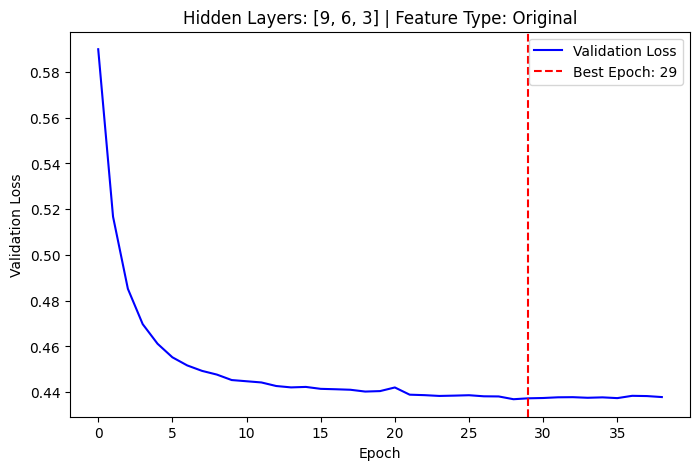

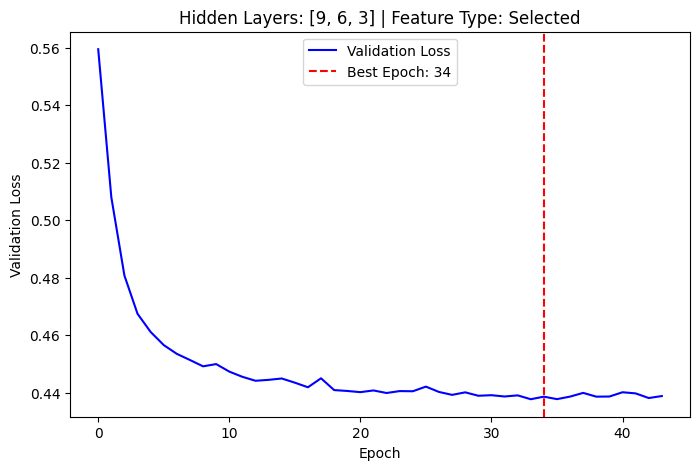

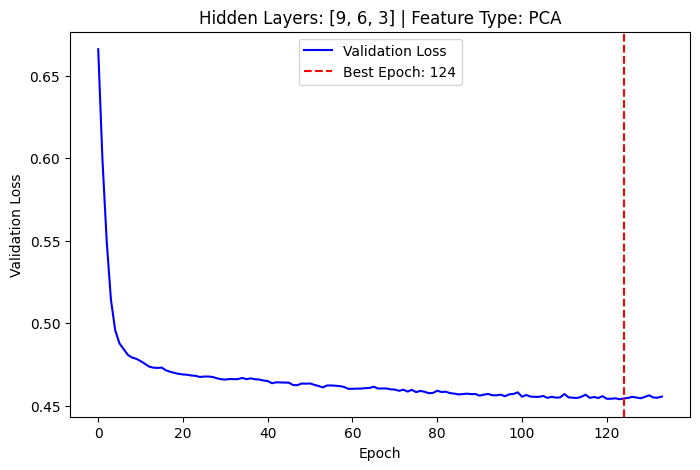

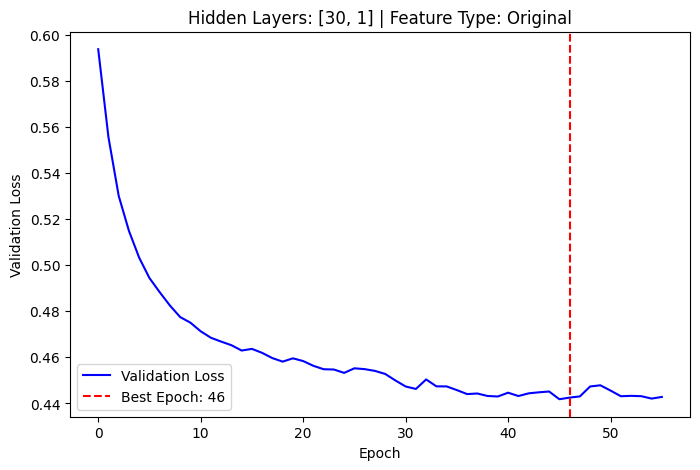

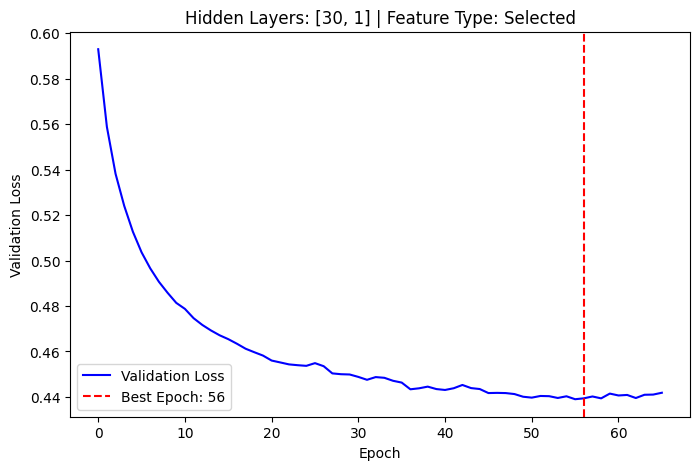

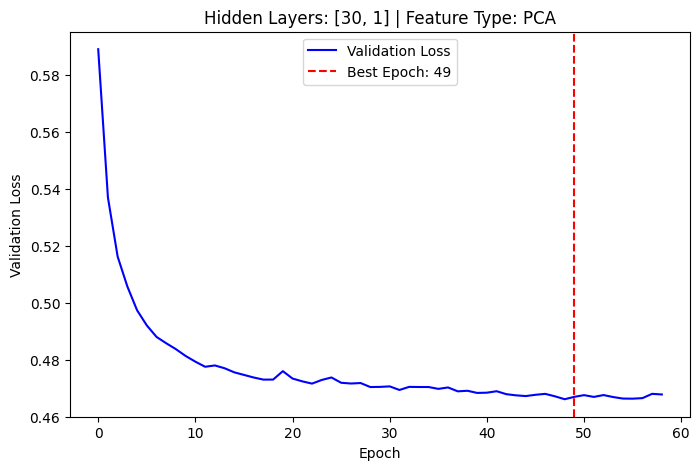

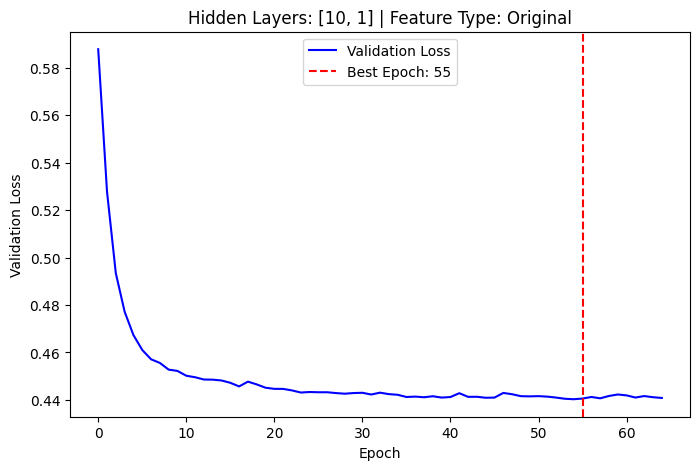

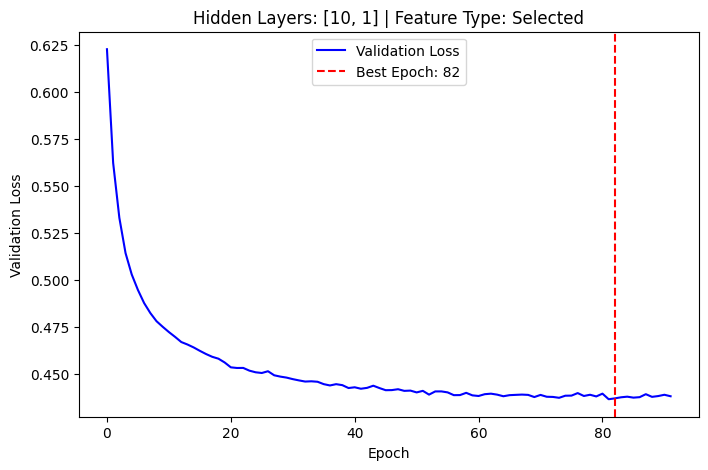

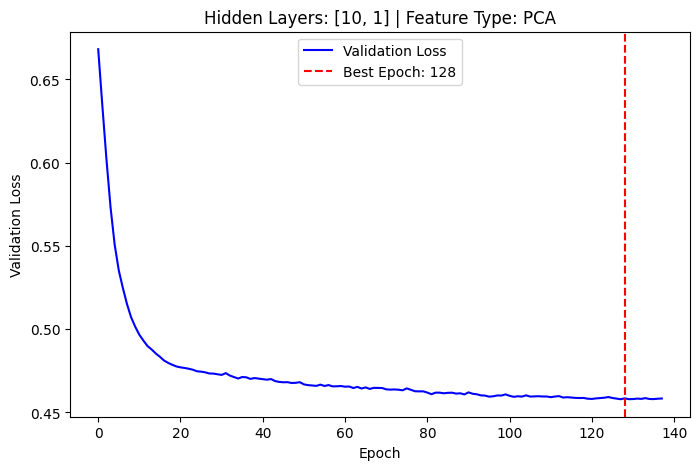

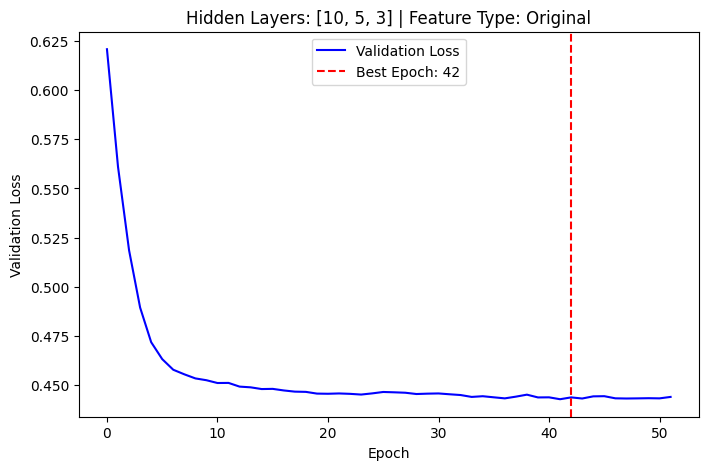

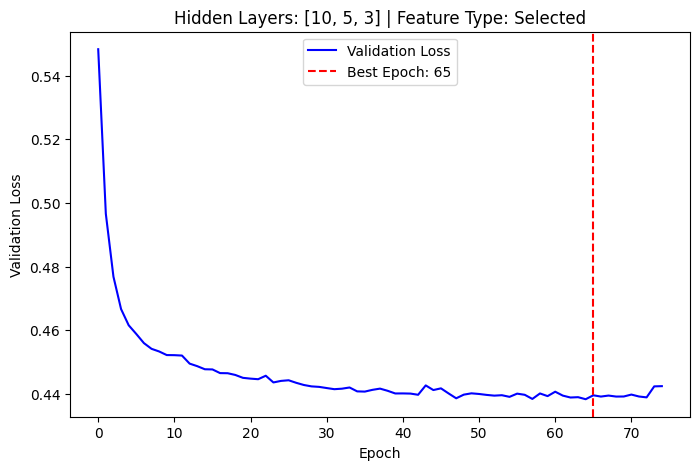

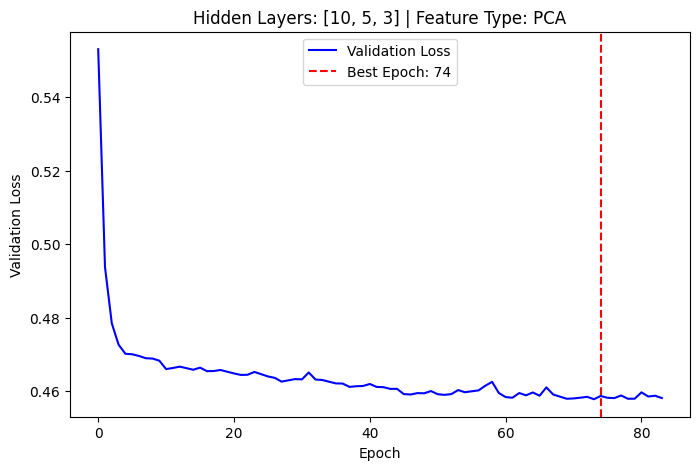

| Hidden Layers   |   Number of Features |   Best Epoch | Feature Type      | Test Performance   |
|:----------------|---------------------:|-------------:|:------------------|:-------------------|
| [9, 6, 3]       |                   19 |           29 | Original Features | 79.9%              |
| [9, 6, 3]       |                   12 |           34 | Selected Features | 79.1%              |
| [9, 6, 3]       |                    8 |          124 | PCA Features      | 80.4%              |
| [30, 1]         |                   19 |           46 | Original Features | 79.5%              |
| [30, 1]         |                   12 |           56 | Selected Features | 80.2%              |
| [30, 1]         |                    8 |           49 | PCA Features      | 78.8%              |
| [10, 1]         |                   19 |           55 | Original Features | 79.7%              |
| [10, 1]         |                   12 |           82 | Selected Features | 79.4%              |
| [10, 1] 

In [ ]:
# Backpropagation (With loss curve)

tf.config.optimizer.set_jit(True)

def train_mlp(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layers, patience):
    model = Sequential()
    for units in hidden_layers:
        model.add(Dense(units, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = keras.optimizers.Adam()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(
        monitor="val_loss", patience=patience, restore_best_weights=True
    )

    history = model.fit(X_train, y_train, epochs=9999999, batch_size=64, verbose=0,
                        validation_data=(X_val, y_val), callbacks=[early_stopping])

    best_epoch = early_stopping.stopped_epoch - patience + 1

    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    test_accuracy = round(test_accuracy * 100, 1)

    return best_epoch, test_accuracy, history

X_train = preprocessed_data["X_train"]
X_val = preprocessed_data["X_val"]
X_test = preprocessed_data["X_test"]
y_train = preprocessed_data["y_train"]
y_val = preprocessed_data["y_val"]
y_test = preprocessed_data["y_test"]

X_train_selected, X_val_selected, X_test_selected, X_train_pca, X_val_pca, X_test_pca = preprocess_features(X_train, y_train, X_val, X_test)

experiments = [[9, 6, 3], [30, 1], [10, 1], [10, 5, 3]]
patience = 10
results = []

feature_counts = {
    "Original": X_train.shape[1],
    "Selected": X_train_selected.shape[1],
    "PCA": X_train_pca.shape[1]
}

for hidden_layers in experiments:

    best_epoch_orig, test_acc_orig, history_orig = train_mlp(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layers, patience)
    best_epoch_selected, test_acc_selected, history_selected = train_mlp(X_train_selected, y_train, X_val_selected, y_val, X_test_selected, y_test, hidden_layers, patience)
    best_epoch_pca, test_acc_pca, history_pca = train_mlp(X_train_pca, y_train, X_val_pca, y_val, X_test_pca, y_test, hidden_layers, patience)

    results.append([str(hidden_layers), feature_counts["Original"], best_epoch_orig, "Original Features", f"{test_acc_orig}%"])
    results.append([str(hidden_layers), feature_counts["Selected"], best_epoch_selected, "Selected Features", f"{test_acc_selected}%"])
    results.append([str(hidden_layers), feature_counts["PCA"], best_epoch_pca, "PCA Features", f"{test_acc_pca}%"])

    for feature_type, history, best_epoch in [
        ("Original", history_orig, best_epoch_orig),
        ("Selected", history_selected, best_epoch_selected),
        ("PCA", history_pca, best_epoch_pca)
    ]:
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['val_loss'], label="Validation Loss", color='blue')
        plt.axvline(best_epoch, linestyle="--", color="red", label=f"Best Epoch: {best_epoch}")
        plt.xlabel("Epoch")
        plt.ylabel("Validation Loss")
        plt.title(f"Hidden Layers: {hidden_layers} | Feature Type: {feature_type}")
        plt.legend()
        plt.show()

columns = ["Hidden Layers", "Number of Features", "Best Epoch", "Feature Type", "Test Performance"]
df = pd.DataFrame(results, columns=columns)

print(df.to_markdown(index=False))

In [ ]:
# Decision Tree Performance Comparison (Without Pruning)

X_train = preprocessed_data["X_train"]
X_val = preprocessed_data["X_val"]
X_test = preprocessed_data["X_test"]
y_train = preprocessed_data["y_train"]
y_test = preprocessed_data["y_test"]

clf = DecisionTreeClassifier(random_state=7404)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
acc_original = accuracy_score(y_test, y_pred) * 100

X_train_selected, X_val_selected, X_test_selected, X_train_pca, X_val_pca, X_test_pca = preprocess_features(X_train, y_train, X_val, X_test)

clf.fit(X_train_selected, y_train)
y_pred_selected = clf.predict(X_test_selected)
acc_filtered = accuracy_score(y_test, y_pred_selected) * 100

clf.fit(X_train_pca, y_train)
y_pred_pca = clf.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca) * 100

table_data = {
    'Performance': [f"{acc_original:.1f}%"],
    'Original Features': [X_train.shape[1]],
    'Correlation Performance': [f"{acc_filtered:.1f}%"],
    'Selected Features': [X_train_selected.shape[1]],
    'PCA Performance': [f"{acc_pca:.1f}%"],
    'PCA Features': [X_train_pca.shape[1]]
}
table_df = pd.DataFrame(table_data)

display(Markdown("### Decision Tree Performance Comparison (Without Pruning)"))
display(table_df.style.set_properties(**{
    'border': '1px solid black',
    'text-align': 'center',
    'font-size': '14px'
}))

### Decision Tree Performance Comparison (Without Pruning)

,Performance,Original Features,Correlation Performance,Selected Features,PCA Performance,PCA Features
0,72.3%,19,73.6%,12,72.9%,8


In [ ]:
# Decision Tree Performance Comparison (With best tree depth)

X_train = preprocessed_data["X_train"]
X_val = preprocessed_data["X_val"]
X_test = preprocessed_data["X_test"]
y_train = preprocessed_data["y_train"]
y_val = preprocessed_data["y_val"]
y_test = preprocessed_data["y_test"]

X_train_selected, X_val_selected, X_test_selected, X_train_pca, X_val_pca, X_test_pca = preprocess_features(X_train, y_train, X_val, X_test)

max_depth_values = range(5, 21)

def find_best_max_depth(X_train, y_train, X_val, y_val):
    val_scores = []
    for depth in max_depth_values:
        clf = DecisionTreeClassifier(random_state=7404, max_depth=depth)
        clf.fit(X_train, y_train)
        y_val_pred = clf.predict(X_val)
        val_scores.append(accuracy_score(y_val, y_val_pred))
    best_depth = max_depth_values[np.argmax(val_scores)]
    best_score = max(val_scores)
    return best_depth, best_score

best_depth_original, best_score_original = find_best_max_depth(X_train, y_train, X_val, y_val)
print(f"Best max_depth for Original Features: {best_depth_original} (Validation Accuracy: {best_score_original:.4f})")

clf_original = DecisionTreeClassifier(random_state=7404, max_depth=best_depth_original)
clf_original.fit(X_train, y_train)
y_pred_original = clf_original.predict(X_test)
acc_original = accuracy_score(y_test, y_pred_original) * 100

best_depth_selected, best_score_selected = find_best_max_depth(X_train_selected, y_train, X_val_selected, y_val)
print(f"Best max_depth for Feature Selection: {best_depth_selected} (Validation Accuracy: {best_score_selected:.4f})")

clf_selected = DecisionTreeClassifier(random_state=7404, max_depth=best_depth_selected)
clf_selected.fit(X_train_selected, y_train)
y_pred_selected = clf_selected.predict(X_test_selected)
acc_selected = accuracy_score(y_test, y_pred_selected) * 100

best_depth_pca, best_score_pca = find_best_max_depth(X_train_pca, y_train, X_val_pca, y_val)
print(f"Best max_depth for PCA: {best_depth_pca} (Validation Accuracy: {best_score_pca:.4f})")

clf_pca = DecisionTreeClassifier(random_state=7404, max_depth=best_depth_pca)
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca) * 100

table_data = {
    'Performance': [f"{acc_original:.1f}%", f"{acc_selected:.1f}%", f"{acc_pca:.1f}%"],
    'Number of Features': [X_train.shape[1], X_train_selected.shape[1], X_train_pca.shape[1]],
    'Feature Selection Method': ['Original Features', 'Correlation Features', 'PCA Features'],
    'Best tree depth': [best_depth_original, best_depth_selected, best_depth_pca]
}

table_df = pd.DataFrame(table_data)

display(Markdown("### Decision Tree: Cross-Validation for ideal tree depth"))
display(table_df.style.set_properties(**{
    'border': '1px solid black',
    'text-align': 'center',
    'font-size': '14px'
}))

Best max_depth for Original Features: 6 (Validation Accuracy: 0.7814)
Best max_depth for Feature Selection: 6 (Validation Accuracy: 0.7850)
Best max_depth for PCA: 5 (Validation Accuracy: 0.7594)


### Decision Tree: Cross-Validation for ideal tree depth

,Performance,Number of Features,Feature Selection Method,Best tree depth
0,78.4%,19,Original Features,6
1,77.9%,12,Correlation Features,6
2,77.8%,8,PCA Features,5


In [ ]:
# Random Forest Performance Comparison (With fixed tree depth)

X_train = preprocessed_data["X_train"]
X_val = preprocessed_data["X_val"]
X_test = preprocessed_data["X_test"]
y_train = preprocessed_data["y_train"]
y_val = preprocessed_data["y_val"]
y_test = preprocessed_data["y_test"]

X_train_selected, X_val_selected, X_test_selected, X_train_pca, X_val_pca, X_test_pca = preprocess_features(X_train, y_train, X_val, X_test)

clf_original = RandomForestClassifier(random_state=7404, n_estimators=100, max_depth=6)
clf_original.fit(X_train, y_train)
y_pred_original = clf_original.predict(X_test)
acc_original = accuracy_score(y_test, y_pred_original) * 100

clf_selected = RandomForestClassifier(random_state=7404, n_estimators=100, max_depth=6)
clf_selected.fit(X_train_selected, y_train)
y_pred_selected = clf_selected.predict(X_test_selected)
acc_selected = accuracy_score(y_test, y_pred_selected) * 100

clf_pca = RandomForestClassifier(random_state=7404, n_estimators=100, max_depth=5)
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca) * 100

table_data = {
    'Performance': [f"{acc_original:.1f}%", f"{acc_selected:.1f}%", f"{acc_pca:.1f}%"],
    'Number of Features': [X_train.shape[1], X_train_selected.shape[1], X_train_pca.shape[1]],
    'Feature Selection Method': ['Original Features', 'Correlation Features', 'PCA Features'],
    'Best tree depth': [6, 6, 5]
}

table_df = pd.DataFrame(table_data)

display(Markdown("### Random Forest Results with Fixed Tree Depths"))
display(table_df.style.set_properties(**{
    'border': '1px solid black',
    'text-align': 'center',
    'font-size': '14px'
}))

### Random Forest Results with Fixed Tree Depths

,Performance,Number of Features,Feature Selection Method,Best tree depth
0,78.1%,19,Original Features,6
1,78.2%,12,Correlation Features,6
2,77.6%,8,PCA Features,5


In [ ]:
# SVM without hyperparameter tuning

X_train = preprocessed_data["X_train"]
X_val = preprocessed_data["X_val"]
X_test = preprocessed_data["X_test"]
y_train = preprocessed_data["y_train"]
y_val = preprocessed_data["y_val"]
y_test = preprocessed_data["y_test"]

X_train_selected, X_val_selected, X_test_selected, X_train_pca, X_val_pca, X_test_pca = preprocess_features(X_train, y_train, X_val, X_test)

svm_model = SVC(kernel='rbf', C=1, gamma=0.1, max_iter=800, cache_size=500, random_state=7404)

svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)
acc_original = accuracy_score(y_test, y_pred) * 100

svm_model.fit(X_train_selected, y_train)
y_pred_selected = svm_model.predict(X_test_selected)
acc_selected = accuracy_score(y_test, y_pred_selected) * 100

svm_model.fit(X_train_pca, y_train)
y_pred_pca = svm_model.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca) * 100

table_data = {
    'Performance': [f"{acc_original:.1f}%", f"{acc_selected:.1f}%", f"{acc_pca:.1f}%"],
    'Number of Features': [X_train.shape[1], X_train_selected.shape[1], X_train_pca.shape[1]],
    'Feature Selection Method': ['Original Features', 'Correlation Features', 'PCA Features'],
}

table_df = pd.DataFrame(table_data)

display(Markdown("### SVM Performance Comparison (Without hyperparameter tuning)"))
display(table_df.style.set_properties(**{
    'border': '1px solid black',
    'text-align': 'center',
    'font-size': '14px'
}))

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### SVM Performance Comparison (Without hyperparameter tuning)

,Performance,Number of Features,Feature Selection Method
0,80.0%,19,Original Features
1,63.7%,12,Correlation Features
2,73.1%,8,PCA Features


In [ ]:
# SVM Performance Comparison (With hyperparameter tuning)

X_train = preprocessed_data["X_train"]
X_val = preprocessed_data["X_val"]
X_test = preprocessed_data["X_test"]
y_train = preprocessed_data["y_train"]
y_val = preprocessed_data["y_val"]
y_test = preprocessed_data["y_test"]

X_train_selected, X_val_selected, X_test_selected, X_train_pca, X_val_pca, X_test_pca = preprocess_features(X_train, y_train, X_val, X_test)

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'sigmoid', 'poly']
}

def manual_grid_search(X_train, y_train, X_val, y_val, param_grid):
    best_params = None
    best_score = 0
    best_model = None

    for C in param_grid['C']:
        for gamma in param_grid['gamma']:
            for kernel in param_grid['kernel']:

                svm_model = SVC(C=C, gamma=gamma, kernel=kernel, random_state=7404, cache_size=500, max_iter=800)
                svm_model.fit(X_train, y_train)

                y_val_pred = svm_model.predict(X_val)
                score = accuracy_score(y_val, y_val_pred)

                if score > best_score:
                    best_params = {'C': C, 'gamma': gamma, 'kernel': kernel}
                    best_score = score
                    best_model = svm_model

    return best_params, best_score, best_model

best_params_original, _, best_svm_original = manual_grid_search(X_train, y_train, X_val, y_val, param_grid)
y_pred = best_svm_original.predict(X_test)
acc_original = accuracy_score(y_test, y_pred) * 100

best_params_selected, _, best_svm_selected = manual_grid_search(X_train_selected, y_train, X_val_selected, y_val, param_grid)
y_pred_selected = best_svm_selected.predict(X_test_selected)
acc_selected = accuracy_score(y_test, y_pred_selected) * 100

best_params_pca, _, best_svm_pca = manual_grid_search(X_train_pca, y_train, X_val_pca, y_val, param_grid)
y_pred_pca = best_svm_pca.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca) * 100

table_data = {
    'Performance': [f"{acc_original:.1f}%", f"{acc_selected:.1f}%", f"{acc_pca:.1f}%"],
    'Feature Selection Method': ['Original Features', 'Correlation Features', 'PCA Features'],
    'Number of Features': [X_train.shape[1], X_train_selected.shape[1], X_train_pca.shape[1]],
    'Best C': [best_params_original['C'], best_params_selected['C'], best_params_pca['C']],
    'Best Gamma': [best_params_original['gamma'], best_params_selected['gamma'], best_params_pca['gamma']],
    'Best Kernel': [best_params_original['kernel'], best_params_selected['kernel'], best_params_pca['kernel']],
}

table_df = pd.DataFrame(table_data)

display(Markdown("### SVM Performance Comparison (With hyperparameter tuning)"))
display(table_df.style.set_properties(**{
    'border': '1px solid black',
    'text-align': 'center',
    'font-size': '14px'
}))

/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=800).  Consider pre-

### SVM Performance Comparison (With hyperparameter tuning)

,Performance,Feature Selection Method,Number of Features,Best C,Best Gamma,Best Kernel
0,80.0%,Original Features,19,1.000000,0.100000,rbf
1,77.0%,Correlation Features,12,10.000000,1.000000,rbf
2,77.1%,PCA Features,8,0.100000,1.000000,rbf


In [ ]:
# Logistic Regression Performance Comparison (Before Regularization tuning)

X_train = preprocessed_data["X_train"]
X_val = preprocessed_data["X_val"]
X_test = preprocessed_data["X_test"]
y_train = preprocessed_data["y_train"]
y_val = preprocessed_data["y_val"]
y_test = preprocessed_data["y_test"]

X_train_selected, X_val_selected, X_test_selected, X_train_pca, X_val_pca, X_test_pca = preprocess_features(X_train, y_train, X_val, X_test)

logreg_model = LogisticRegression(max_iter=800, solver='lbfgs', random_state=7404)

logreg_model.fit(X_train, y_train)
y_pred = logreg_model.predict(X_test)
acc_original = accuracy_score(y_test, y_pred) * 100

logreg_model.fit(X_train_selected, y_train)
y_pred_selected = logreg_model.predict(X_test_selected)
acc_selected = accuracy_score(y_test, y_pred_selected) * 100

logreg_model.fit(X_train_pca, y_train)
y_pred_pca = logreg_model.predict(X_test_pca)
acc_pca = accuracy_score(y_test, y_pred_pca) * 100

data = {
    'Performance': [f"{acc_original:.1f}%", f"{acc_selected:.1f}%", f"{acc_pca:.1f}%"],
    'Number of Features': [X_train.shape[1], X_train_selected.shape[1], X_train_pca.shape[1]],
    'Feature Selection Method': ['Original Features', 'Correlation Features', 'PCA Features'],
}

table_df = pd.DataFrame(data)

display(Markdown("### LOGISTIC REGRESSION RESULTS OF THE EXPERIMENT"))
display(table_df.style.set_properties(**{
    'border': '1px solid black',
    'text-align': 'center',
    'font-size': '14px'
}).set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]}
]))

### LOGISTIC REGRESSION RESULTS OF THE EXPERIMENT

,Performance,Number of Features,Feature Selection Method
0,79.9%,19,Original Features
1,79.6%,12,Correlation Features
2,78.6%,8,PCA Features


In [ ]:
# Logistic Regression Performance Comparison (With Regularization tuning)

X_train = preprocessed_data["X_train"]
X_val = preprocessed_data["X_val"]
X_test = preprocessed_data["X_test"]
y_train = preprocessed_data["y_train"]
y_val = preprocessed_data["y_val"]
y_test = preprocessed_data["y_test"]

X_train_selected, X_val_selected, X_test_selected, X_train_pca, X_val_pca, X_test_pca = preprocess_features(X_train, y_train, X_val, X_test)

C_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]

def find_best_C(X_train, y_train, X_val, y_val, C_values, penalty):
    best_C = None
    best_score = 0
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'

    for C in C_values:
        model = LogisticRegression(penalty=penalty, solver=solver, C=C, max_iter=800, random_state=7404)
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        score = accuracy_score(y_val, y_val_pred)

        if score > best_score:
            best_C = C
            best_score = score

    return best_C, best_score

best_C_l1_original, _ = find_best_C(X_train, y_train, X_val, y_val, C_values, penalty='l1')
best_C_l2_original, _ = find_best_C(X_train, y_train, X_val, y_val, C_values, penalty='l2')

best_C_l1_selected, _ = find_best_C(X_train_selected, y_train, X_val_selected, y_val, C_values, penalty='l1')
best_C_l2_selected, _ = find_best_C(X_train_selected, y_train, X_val_selected, y_val, C_values, penalty='l2')

best_C_l1_pca, _ = find_best_C(X_train_pca, y_train, X_val_pca, y_val, C_values, penalty='l1')
best_C_l2_pca, _ = find_best_C(X_train_pca, y_train, X_val_pca, y_val, C_values, penalty='l2')

def train_and_evaluate(X_train, y_train, X_test, y_test, best_C, penalty):
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    model = LogisticRegression(penalty=penalty, solver=solver, C=best_C, max_iter=1000, random_state=7404)
    model.fit(X_train, y_train)
    acc = accuracy_score(y_test, model.predict(X_test)) * 100

    if penalty == 'l1':
        nonzero_features = (model.coef_ != 0).sum()
    else:
        nonzero_features = X_train.shape[1]

    return acc, nonzero_features

acc_l1_original, nonzero_features_l1_original = train_and_evaluate(X_train, y_train, X_test, y_test, best_C_l1_original, penalty='l1')
acc_l2_original, nonzero_features_l2_original = train_and_evaluate(X_train, y_train, X_test, y_test, best_C_l2_original, penalty='l2')

acc_l1_selected, nonzero_features_l1_selected = train_and_evaluate(X_train_selected, y_train, X_test_selected, y_test, best_C_l1_selected, penalty='l1')
acc_l2_selected, nonzero_features_l2_selected = train_and_evaluate(X_train_selected, y_train, X_test_selected, y_test, best_C_l2_selected, penalty='l2')

acc_l1_pca, nonzero_features_l1_pca = train_and_evaluate(X_train_pca, y_train, X_test_pca, y_test, best_C_l1_pca, penalty='l1')
acc_l2_pca, nonzero_features_l2_pca = train_and_evaluate(X_train_pca, y_train, X_test_pca, y_test, best_C_l2_pca, penalty='l2')

table_data = {
    'Performance': [
        f"{acc_l1_original:.1f}%", f"{acc_l1_selected:.1f}%", f"{acc_l1_pca:.1f}%",
        f"{acc_l2_original:.1f}%", f"{acc_l2_selected:.1f}%", f"{acc_l2_pca:.1f}%"
    ],
    'Number of Features': [
        nonzero_features_l1_original, nonzero_features_l1_selected, nonzero_features_l1_pca,
        nonzero_features_l2_original, nonzero_features_l2_selected, nonzero_features_l2_pca
    ],
    'Regularization': [
        "L1 (Lasso)", "L1 (Lasso)", "L1 (Lasso)",
        "L2 (Ridge)", "L2 (Ridge)", "L2 (Ridge)"
    ],
    'Feature Selection Method': [
        "Original Features", "Correlation Features", "PCA Features",
        "Original Features", "Correlation Features", "PCA Features"
    ],
    'Best C': [
        best_C_l1_original, best_C_l1_selected, best_C_l1_pca,
        best_C_l2_original, best_C_l2_selected, best_C_l2_pca
    ]
}

table_df = pd.DataFrame(table_data)

display(Markdown("### Logistic Regression Performance Comparison (With Regularization tuning)"))
display(table_df.style.set_properties(**{
    'border': '1px solid black',
    'text-align': 'center',
    'font-size': '14px'
}))

### Logistic Regression Performance Comparison (With Regularization tuning)

,Performance,Number of Features,Regularization,Feature Selection Method,Best C
0,79.6%,15,L1 (Lasso),Original Features,0.100000
1,79.6%,12,L1 (Lasso),Correlation Features,100.000000
2,78.6%,8,L1 (Lasso),PCA Features,1.000000
3,79.8%,19,L2 (Ridge),Original Features,0.100000
4,78.9%,12,L2 (Ridge),Correlation Features,0.050000
5,78.6%,8,L2 (Ridge),PCA Features,0.500000


### DBSCAN CLUSTERING RESULTS OF CLUSTER_0

,Cluster,Churn (no),Churn (yes),Total
0,cluster_0,4224,1522,5746


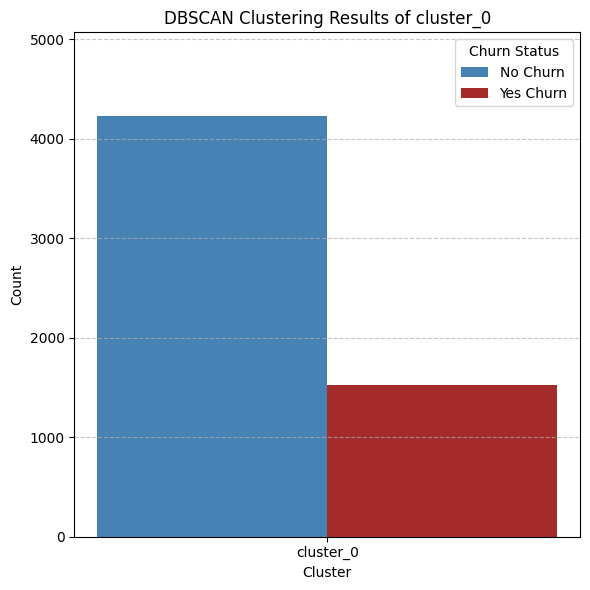

In [ ]:
# DBSCAN Clustering - Cluster 0

def display_dbscan_cluster_result(cluster_df, cluster_label):
    churn_counts = cluster_df['Churn'].value_counts()
    no_churn = churn_counts.get(0, 0)
    yes_churn = churn_counts.get(1, 0)
    total = no_churn + yes_churn

    table_data = {
        'Cluster': [cluster_label],
        'Churn (no)': [no_churn],
        'Churn (yes)': [yes_churn],
        'Total': [total]
    }
    table_df = pd.DataFrame(table_data)

    display(Markdown(f"### DBSCAN CLUSTERING RESULTS OF {cluster_label.upper()}"))
    display(table_df.style.set_properties(**{
        'border': '1px solid black',
        'text-align': 'center',
        'font-size': '14px'
    }).set_table_styles([
        {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]}
    ]))

    fig, ax = plt.subplots(figsize=(6, 6))

    labels = [cluster_label]
    bar_width = 0.4
    x = np.arange(len(labels))
    x1 = x - bar_width / 2
    x2 = x + bar_width / 2

    ax.bar(x1, [no_churn], bar_width, label="No Churn", color="steelblue")
    ax.bar(x2, [yes_churn], bar_width, label="Yes Churn", color="brown")

    ax.set_ylim(0, max(no_churn, yes_churn) * 1.2)
    ax.set_ylabel("Count")
    ax.set_xlabel("Cluster")
    ax.set_title(f"DBSCAN Clustering Results of {cluster_label}")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(title="Churn Status", loc="upper right")
    ax.yaxis.grid(True, linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

X_scaled = preprocessed_data["X_scaled"]
df = pd.read_csv('processed_data.csv')

dbscan = DBSCAN(eps=0.5, min_samples=5)
df['Cluster'] = dbscan.fit_predict(X_scaled)
df['Cluster'] = np.where(df['Cluster'] == -1, 0, 1)

cluster_0 = df[df['Cluster'] == 0]
display_dbscan_cluster_result(cluster_0, "cluster_0")

### DBSCAN CLUSTERING RESULTS OF CLUSTER_1

,Cluster,Churn (no),Churn (yes),Total
0,cluster_1,950,347,1297


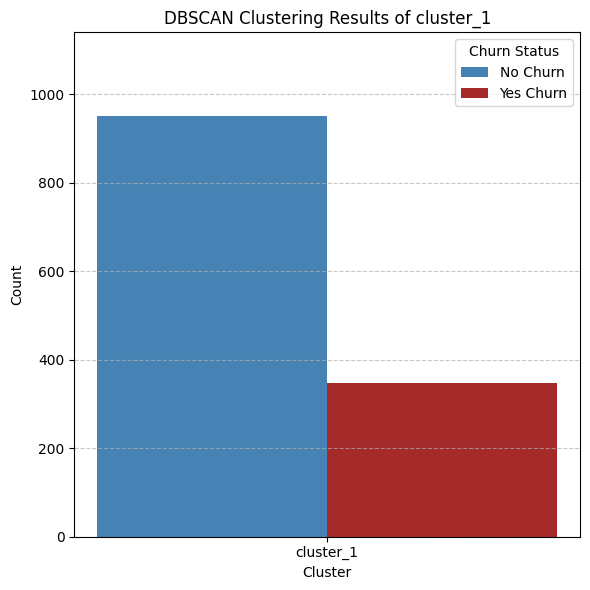

In [ ]:
# DBSCAN Clustering - Cluster 1

cluster_1 = df[df['Cluster'] == 1]
display_dbscan_cluster_result(cluster_1, "cluster_1")

### DBSCAN CLUSTERING RESULTS OF THE EXPERIMENT

,Cluster,Churn (no),Churn (yes),Total
0,Cluster 0,4224,1522,5746
1,Cluster 1,950,347,1297
2,Grand Total,5174,1869,7043


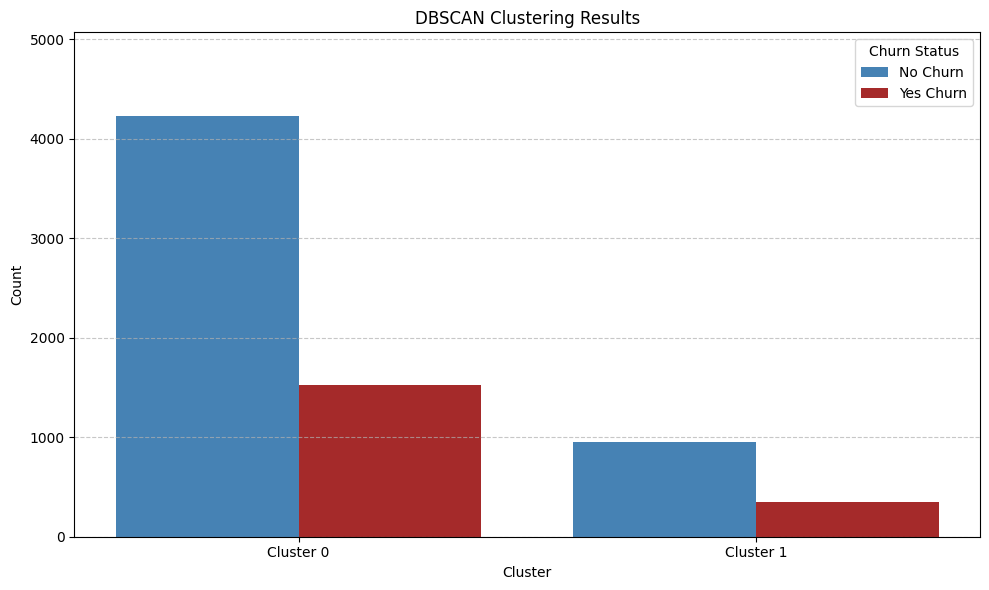

In [ ]:
# DBSCAN Clustering - Cluster 0 and Cluster 1

X_scaled = preprocessed_data["X_scaled"]
df = pd.read_csv('processed_data.csv')

dbscan = DBSCAN(eps=0.5, min_samples=5)
df['Cluster'] = dbscan.fit_predict(X_scaled)

df['Cluster'] = np.where(df['Cluster'] == -1, 0, 1)

cluster_0 = df[df['Cluster'] == 0]
cluster_1 = df[df['Cluster'] == 1]

churn_counts_0 = cluster_0['Churn'].value_counts()
churn_counts_1 = cluster_1['Churn'].value_counts()

no_churn_0 = churn_counts_0.get(0, 0)
yes_churn_0 = churn_counts_0.get(1, 0)
total_0 = no_churn_0 + yes_churn_0

no_churn_1 = churn_counts_1.get(0, 0)
yes_churn_1 = churn_counts_1.get(1, 0)
total_1 = no_churn_1 + yes_churn_1

total_no_churn = no_churn_0 + no_churn_1
total_yes_churn = yes_churn_0 + yes_churn_1
grand_total = total_0 + total_1

table_data = {
    'Cluster': ['Cluster 0', 'Cluster 1', 'Grand Total'],
    'Churn (no)': [no_churn_0, no_churn_1, total_no_churn],
    'Churn (yes)': [yes_churn_0, yes_churn_1, total_yes_churn],
    'Total': [total_0, total_1, grand_total]
}

table_df = pd.DataFrame(table_data)

display(Markdown("### DBSCAN CLUSTERING RESULTS OF THE EXPERIMENT"))

display(table_df.style.set_properties(**{
    'border': '1px solid black',
    'text-align': 'center',
    'font-size': '14px'
}).set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]}
]))

fig, ax = plt.subplots(figsize=(10, 6))

labels = ["Cluster 0", "Cluster 1"]
bar_width = 0.4

x = np.arange(len(labels))
x1 = x - bar_width / 2
x2 = x + bar_width / 2

bars_no = [no_churn_0, no_churn_1]
bars_yes = [yes_churn_0, yes_churn_1]

ax.bar(x1, bars_no, bar_width, label="No Churn", color="steelblue")
ax.bar(x2, bars_yes, bar_width, label="Yes Churn", color="brown")

max_height = max(bars_no + bars_yes)
ax.set_ylim(0, max_height * 1.2)

ax.set_ylabel("Count")
ax.set_xlabel("Cluster")
ax.set_title("DBSCAN Clustering Results")

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(title="Churn Status", loc="upper right")
ax.yaxis.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

### KMEAN CLUSTERING RESULTS OF CLUSTER_0

,Cluster,Churn (no),Churn (yes),Total
0,cluster_0,3761,1756,5517


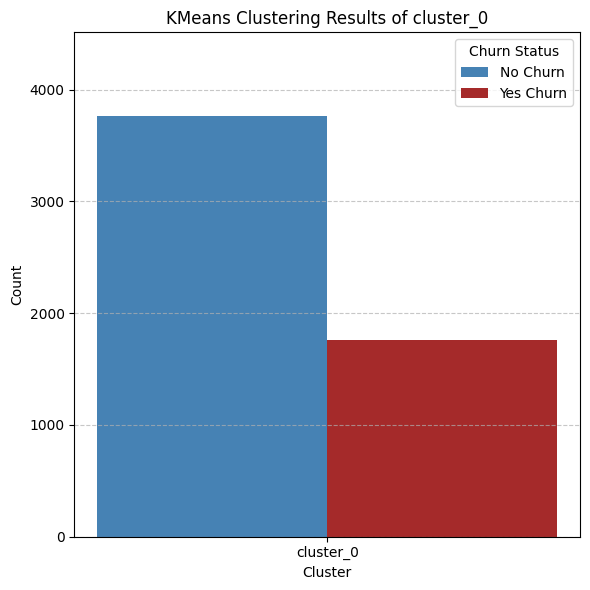

In [ ]:
# KMEAN Clustering - Cluster 0

def display_kmeans_cluster_result(cluster_df, cluster_label):
    churn_counts = cluster_df['Churn'].value_counts()
    no_churn = churn_counts.get(0, 0)
    yes_churn = churn_counts.get(1, 0)
    total = no_churn + yes_churn

    table_data = {
        'Cluster': [cluster_label],
        'Churn (no)': [no_churn],
        'Churn (yes)': [yes_churn],
        'Total': [total]
    }
    table_df = pd.DataFrame(table_data)

    display(Markdown(f"### KMEAN CLUSTERING RESULTS OF {cluster_label.upper()}"))
    display(table_df.style.set_properties(**{
        'border': '1px solid black',
        'text-align': 'center',
        'font-size': '14px'
    }).set_table_styles([
        {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]}
    ]))

    fig, ax = plt.subplots(figsize=(6, 6))
    labels = [cluster_label]
    bar_width = 0.4
    x = np.arange(len(labels))
    x1 = x - bar_width / 2
    x2 = x + bar_width / 2

    ax.bar(x1, [no_churn], bar_width, label="No Churn", color="steelblue")
    ax.bar(x2, [yes_churn], bar_width, label="Yes Churn", color="brown")

    ax.set_ylim(0, max(no_churn, yes_churn) * 1.2)
    ax.set_ylabel("Count")
    ax.set_xlabel("Cluster")
    ax.set_title(f"KMeans Clustering Results of {cluster_label}")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(title="Churn Status", loc="upper right")
    ax.yaxis.grid(True, linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()

X_scaled = preprocessed_data["X_scaled"]
df = pd.read_csv('processed_data.csv')

kmeans = KMeans(n_clusters=2, random_state=7404, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_0 = df[df['Cluster'] == 0]

display_kmeans_cluster_result(cluster_0, "cluster_0")

### KMEAN CLUSTERING RESULTS OF CLUSTER_1

,Cluster,Churn (no),Churn (yes),Total
0,cluster_1,1413,113,1526


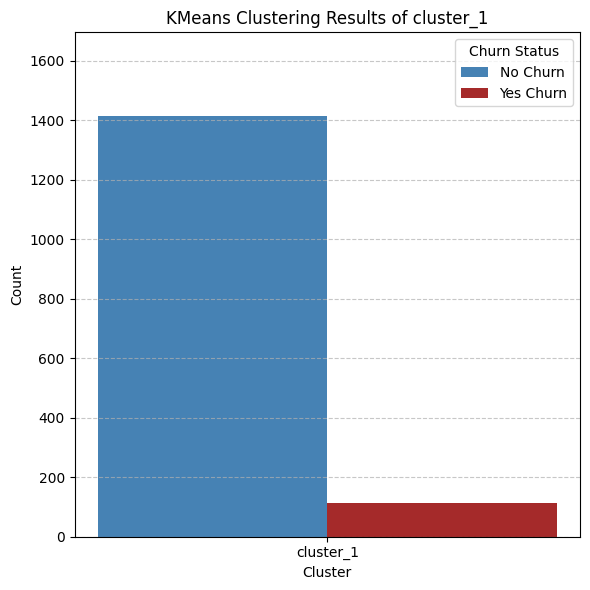

In [ ]:
# KMEAN CLUSTERING - Cluster 1

cluster_1 = df[df['Cluster'] == 1]

display_kmeans_cluster_result(cluster_1, "cluster_1")

### KMEAN CLUSTERING RESULTS OF THE EXPERIMENT

,Cluster,Churn (no),Churn (yes),Total
0,Cluster 0,3761,1756,5517
1,Cluster 1,1413,113,1526
2,Grand Total,5174,1869,7043


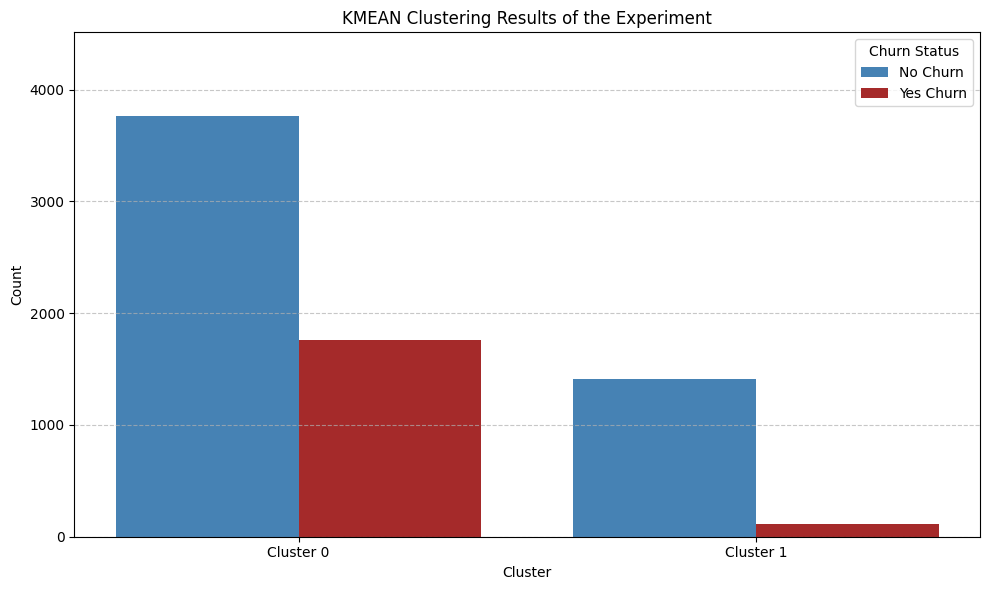

In [ ]:
# KMEAN CLUSTERING

kmeans = KMeans(n_clusters=2, random_state=7404, n_init=50)
df['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_0 = df[df['Cluster'] == 0]
cluster_1 = df[df['Cluster'] == 1]

churn_counts_0 = cluster_0['Churn'].value_counts()
churn_counts_1 = cluster_1['Churn'].value_counts()

no_churn_0 = churn_counts_0.get(0, 0)
yes_churn_0 = churn_counts_0.get(1, 0)
total_0 = no_churn_0 + yes_churn_0

no_churn_1 = churn_counts_1.get(0, 0)
yes_churn_1 = churn_counts_1.get(1, 0)
total_1 = no_churn_1 + yes_churn_1

total_no_churn = no_churn_0 + no_churn_1
total_yes_churn = yes_churn_0 + yes_churn_1
grand_total = total_0 + total_1

table_data = {
    'Cluster': ['Cluster 0', 'Cluster 1', 'Grand Total'],
    'Churn (no)': [no_churn_0, no_churn_1, total_no_churn],
    'Churn (yes)': [yes_churn_0, yes_churn_1, total_yes_churn],
    'Total': [total_0, total_1, grand_total]
}

table_df = pd.DataFrame(table_data)

display(Markdown("### KMEAN CLUSTERING RESULTS OF THE EXPERIMENT"))
display(table_df.style.set_properties(**{
    'border': '1px solid black',
    'text-align': 'center',
    'font-size': '14px'
}).set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]}
]))

fig, ax = plt.subplots(figsize=(10, 6))

labels = ["Cluster 0", "Cluster 1"]
bar_width = 0.4

x = np.arange(len(labels))
x1 = x - bar_width / 2
x2 = x + bar_width / 2

bars_no = [no_churn_0, no_churn_1]
bars_yes = [yes_churn_0, yes_churn_1]

ax.bar(x1, bars_no, bar_width, label="No Churn", color="steelblue")
ax.bar(x2, bars_yes, bar_width, label="Yes Churn", color="brown")

max_height = max(bars_no + bars_yes)
ax.set_ylim(0, max_height * 1.2)

ax.set_ylabel("Count")
ax.set_xlabel("Cluster")
ax.set_title("KMEAN Clustering Results of the Experiment")
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend(title="Churn Status", loc="upper right")
ax.yaxis.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

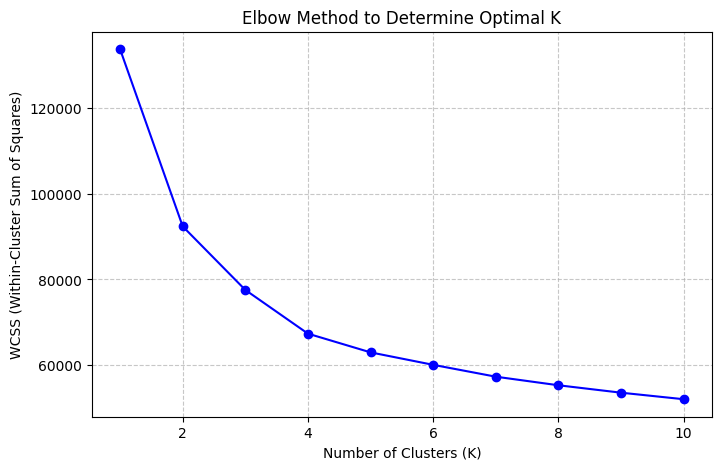

In [ ]:
# K mean elbow method

X_scaled = preprocessed_data["X_scaled"]
df = pd.read_csv('processed_data.csv')

wcss = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=7404, n_init=50)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method to Determine Optimal K")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

### **K-Means Clustering Results (K=4) with Grand Total**

,Cluster,Churn (no),Churn (yes),Total
0,Cluster 0,1536,1305,2841
1,Cluster 1,1413,113,1526
2,Cluster 2,1713,281,1994
3,Cluster 3,512,170,682
4,Grand Total,5174,1869,7043


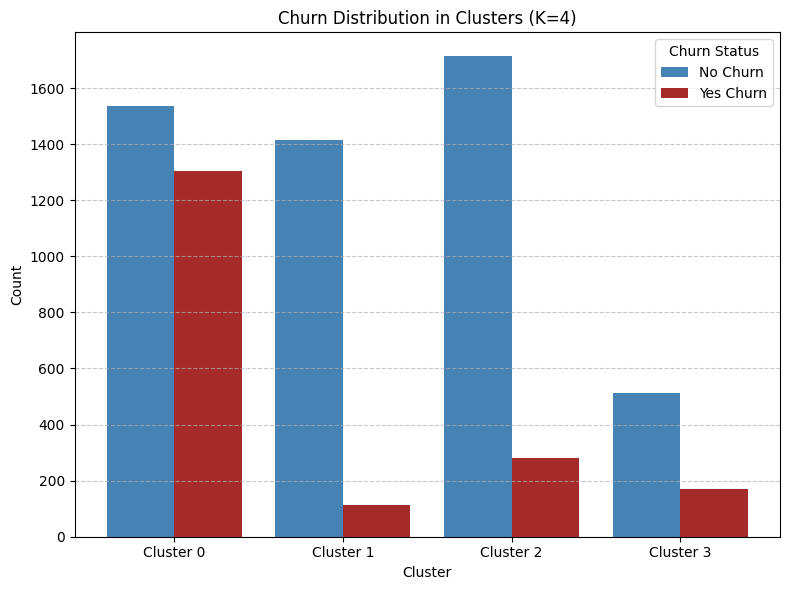

In [ ]:
# KMEAN CLUSTERING (k=4)

X_scaled = preprocessed_data["X_scaled"]
df = pd.read_csv('processed_data.csv')

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=7404, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

cluster_summary = []
grand_no_churn = 0
grand_yes_churn = 0
grand_total = 0

for cluster in range(n_clusters):
    cluster_data = df[df['Cluster'] == cluster]
    churn_counts = cluster_data['Churn'].value_counts()

    no_churn = churn_counts.get(0, 0)
    yes_churn = churn_counts.get(1, 0)
    total = no_churn + yes_churn

    grand_no_churn += no_churn
    grand_yes_churn += yes_churn
    grand_total += total

    cluster_summary.append([f"Cluster {cluster}", no_churn, yes_churn, total])

cluster_summary.append(["Grand Total", grand_no_churn, grand_yes_churn, grand_total])

table_df = pd.DataFrame(cluster_summary, columns=["Cluster", "Churn (no)", "Churn (yes)", "Total"])

display(Markdown("### **K-Means Clustering Results (K=4) with Grand Total**"))
display(table_df.style.set_properties(**{
    'border': '1px solid black',
    'text-align': 'center',
    'font-size': '14px'
}).set_table_styles([
    {'selector': 'th', 'props': [('font-weight', 'bold'), ('text-align', 'center')]}
]))

fig, ax = plt.subplots(figsize=(8, 6))

labels = [f"Cluster {i}" for i in range(n_clusters)]
bar_width = 0.4
x = np.arange(len(labels))

no_churn_values = [table_df.iloc[i]["Churn (no)"] for i in range(n_clusters)]
yes_churn_values = [table_df.iloc[i]["Churn (yes)"] for i in range(n_clusters)]

ax.bar(x - bar_width / 2, no_churn_values, bar_width, label="No Churn", color="steelblue")
ax.bar(x + bar_width / 2, yes_churn_values, bar_width, label="Yes Churn", color="brown")

ax.set_xlabel("Cluster")
ax.set_ylabel("Count")
ax.set_title("Churn Distribution in Clusters (K=4)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(title="Churn Status", loc="upper right")
ax.yaxis.grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# Association rule (Apriori)

df = pd.read_csv('processed_data.csv')

rules = [
    ("InternetService= fiber optic", (df['InternetService'] == 2), "PhoneService=yes"),
    ("SeniorCitizen=0 InternetService=2", (df['SeniorCitizen'] == 0) & (df['InternetService'] == 2), "PhoneService=yes"),
    ("MultipleLines=no", (df['MultipleLines'] == 0), "PhoneService=yes"),
    ("Dependents=no InternetService=fiber optic", (df['Dependents'] == 0) & (df['InternetService'] == 2), "PhoneService=yes"),
    ("InternetService=fiber optic Churn=no", (df['InternetService'] == 2) & (df['Churn'] == 0), "PhoneService=yes"),
    ("SeniorCitizen=0 MultipleLines=no", (df['SeniorCitizen'] == 0) & (df['MultipleLines'] == 0), "PhoneService=yes"),
    ("MultipleLines=yes", (df['MultipleLines'] == 1), "PhoneService=yes"),
    ("InternetService=fiber optic PaperlessBilling=yes", (df['InternetService'] == 2) & (df['PaperlessBilling'] == 1), "PhoneService=yes"),
    ("SeniorCitizen=0 InternetService=fiber optic Churn=no", (df['SeniorCitizen'] == 0) & (df['InternetService'] == 2) & (df['Churn'] == 0), "PhoneService=yes"),
    ("InternetService=fiber optic Contract=month-to-month", (df['InternetService'] == 2) & (df['Contract'] == 0), "PhoneService=yes"),
]

print("Apriori")

for idx, (antecedent, condition, consequent) in enumerate(rules, start=1):
    support_count = len(df[condition])
    confidence = 1

    print(f"{idx}. {antecedent} {support_count} ==> {consequent} {support_count} conf :( {confidence} )")

Apriori
1. InternetService= fiber optic 3096 ==> PhoneService=yes 3096 conf :( 1 )
2. SeniorCitizen=0 InternetService=2 2265 ==> PhoneService=yes 2265 conf :( 1 )
3. MultipleLines=no 682 ==> PhoneService=yes 682 conf :( 1 )
4. Dependents=no InternetService=fiber optic 2434 ==> PhoneService=yes 2434 conf :( 1 )
5. InternetService=fiber optic Churn=no 1799 ==> PhoneService=yes 1799 conf :( 1 )
6. SeniorCitizen=0 MultipleLines=no 578 ==> PhoneService=yes 578 conf :( 1 )
7. MultipleLines=yes 2971 ==> PhoneService=yes 2971 conf :( 1 )
8. InternetService=fiber optic PaperlessBilling=yes 2395 ==> PhoneService=yes 2395 conf :( 1 )
9. SeniorCitizen=0 InternetService=fiber optic Churn=no 1361 ==> PhoneService=yes 1361 conf :( 1 )
10. InternetService=fiber optic Contract=month-to-month 2128 ==> PhoneService=yes 2128 conf :( 1 )


In [ ]:
# Association rule (FP-Growth)

df = pd.read_csv('processed_data.csv')

rules = [
    (["InternetService= DSL"], (df['InternetService'] == 1), ["PhoneService=yes"]),
    (["MultipleLines=no"], (df['MultipleLines'] == 0), ["PhoneService=yes"]),
    (["MultipleLines=yes"], (df['MultipleLines'] == 1), ["PhoneService=yes"]),
    (["InternetService= DSL", "PaperlessBilling=yes"], (df['InternetService'] == 1) & (df['PaperlessBilling'] == 1), ["PhoneService=yes"]),
    (["InternetService= DSL", "Contract=month-to-month"], (df['InternetService'] == 1) & (df['Contract'] == 0), ["PhoneService=yes"]),
    (["InternetService= DSL", "gender=male"], (df['InternetService'] == 1) & (df['gender'] == 1), ["PhoneService=yes"]),
    (["InternetService= DSL", "OnlineSecurity=no"], (df['InternetService'] == 1) & (df['OnlineSecurity'] == 0), ["PhoneService=yes"]),
    (["InternetService= DSL", "TechSupport=no"], (df['InternetService'] == 1) & (df['TechSupport'] == 0), ["PhoneService=yes"]),
    (["InternetService= DSL", "Partner=yes"], (df['InternetService'] == 1) & (df['Partner'] == 1), ["PhoneService=yes"]),
    (["InternetService= DSL", "MultipleLines=no"], (df['InternetService'] == 1) & (df['MultipleLines'] == 0), ["PhoneService=yes"]),
]

print("FP-Growth")

for idx, (antecedents, condition, consequents) in enumerate(rules, start=1):
    support_count = len(df[condition])
    confidence = 1

    antecedents_str = ", ".join(antecedents)
    consequents_str = ", ".join(consequents)

    print(f"{idx}. [{antecedents_str}]: {support_count} ==> [{consequents_str}]: {support_count} conf :( {confidence} )")

FP-Growth
1. [InternetService= DSL]: 2421 ==> [PhoneService=yes]: 2421 conf :( 1 )
2. [MultipleLines=no]: 682 ==> [PhoneService=yes]: 682 conf :( 1 )
3. [MultipleLines=yes]: 2971 ==> [PhoneService=yes]: 2971 conf :( 1 )
4. [InternetService= DSL, PaperlessBilling=yes]: 1330 ==> [PhoneService=yes]: 1330 conf :( 1 )
5. [InternetService= DSL, Contract=month-to-month]: 1223 ==> [PhoneService=yes]: 1223 conf :( 1 )
6. [InternetService= DSL, gender=male]: 1233 ==> [PhoneService=yes]: 1233 conf :( 1 )
7. [InternetService= DSL, OnlineSecurity=no]: 0 ==> [PhoneService=yes]: 0 conf :( 1 )
8. [InternetService= DSL, TechSupport=no]: 0 ==> [PhoneService=yes]: 0 conf :( 1 )
9. [InternetService= DSL, Partner=yes]: 1168 ==> [PhoneService=yes]: 1168 conf :( 1 )
10. [InternetService= DSL, MultipleLines=no]: 682 ==> [PhoneService=yes]: 682 conf :( 1 )
